In [41]:
import numpy as np
import time
import argparse
import json
from math import sqrt, ceil
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# load data set
#def load_dataset(file_path='dataset.csv', header_row_index=0, index_col_name =None, col_to_predict, cols_to_drop=None):
def _load_dataset(file_path, header_row_index, index_col_name, col_to_predict, cols_to_drop):

    """
    file_path: the csv file path
    header_row_index: the header row index in the csv file
    index_col_name: the index column (can be None if no index is there)
    col_to_predict: the column name/index to predict
    cols_to_drop: the column names/indices to drop (single label or list-like)
    """
    # read dataset from disk
    dataset = read_csv(file_path, header=header_row_index, index_col=False)
    #print(dataset)

    # set index col, set index column, parameter input column name list
    if index_col_name:
        dataset.set_index(index_col_name, inplace=True)

        # drop nonused colums, delete unnecessary columns, parameter input column name list
    '''if cols_to_drop:
        if type(cols_to_drop[0]) == int:
            dataset.drop(index=cols_to_drop, axis=0, inplace=True)
        else:
            dataset.drop(columns=cols_to_drop, axis=1, inplace=True)'''
    if cols_to_drop:
        dataset.drop(cols_to_drop, axis =1, inplace = True)

    #print('\nprint data set again\n',dataset)
    # get rows and column names
    col_names = dataset.columns.values.tolist()
    values = dataset.values
    #print(col_names, '\n values\n', values)

    # move the column to predict to be the first col: adjust the predicted column to the first column
    col_to_predict_index = col_to_predict if type(col_to_predict) == int else col_names.index(col_to_predict)
    output_col_name = col_names[col_to_predict_index]
    if col_to_predict_index > 0:
        col_names = [col_names[col_to_predict_index]] + col_names[:col_to_predict_index] + col_names[col_to_predict_index+1:]
    values = np.concatenate((values[:, col_to_predict_index].reshape((values.shape[0], 1)), values[:,:col_to_predict_index], values[:,col_to_predict_index+1:]), axis=1)
    #print(col_names, '\n values2\n', values)
    # ensure all data is float
    values = values.astype("float32")
    #print(col_names, '\n values3\n', values)
    return col_names, values,values.shape[1], output_col_name
# scale dataset
#def _scale_dataset(values, scale_range = (0,1)):
def _scale_dataset(values, scale_range):
    """
    values: dataset values
    scale_range: scale range to fit data in
    """
    # normalize features
    scaler = MinMaxScaler(feature_range=scale_range or (0, 1))
    scaled = scaler.fit_transform(values)

    return (scaler, scaled)
# convert series to supervised learning (ex: var1(t)_row1 = var1(t-1)_row2), the list is printed out and you will understand at a glance
#def _series_to_supervised(values, n_in=3, n_out=1, dropnan=True, col_names, verbose=True):

def _series_to_supervised(values, n_in, n_out, dropnan, col_names, verbose):
    n_vars = 1 if type(values) is list else values.shape[1]
    if col_names is None:
        col_names = ["var%d" % (j + 1) for j in range(n_vars)]
    df = DataFrame(values)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("%s(t-%d)" % (col_names[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("%s(t)" % (col_names[j])) for j in range(n_vars)]
        else:
            names += [("%s(t+%d)" % (col_names[j], i)) for j in range(n_vars)]

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    if verbose:
        print("\nsupervised data shape:", agg.shape)
    return agg




In [42]:
# split into train and test sets
#def _split_data_to_train_test_sets(values, n_intervals=3, n_features, train_percentage=0.67, verbose=True):
def _split_data_to_train_test_sets(values, n_intervals, n_features, train_percentage, verbose):
    """
    values: dataset supervised values
    n_intervals: number of time lags (intervals) to use in each neuron
    n_features: number of features (variables) per neuron
    train_percentage: percentage of train data related to the dataset series size; (1-train_percentage) will be for test data
    verbose: whether to output some debug data
    """

    n_train_intervals = ceil(values.shape[0] * train_percentage) #ceil(x)-> get the closest integer not less than x, such as ceil(2.001)=3
    train = values[:n_train_intervals, :]
    test = values[n_train_intervals:, :]

    # split into input and outputs
    n_obs = n_intervals * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features] #train_Y directly assigns the penultimate column, which is exactly the number 0 to be predicted at time t + n_out_timestep-1
        #train_X The shape at this time is [train.shape[0], timesteps * features]
    #print('before reshape\ntrain_X shape:', train_X.shape)
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_intervals, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_intervals, n_features))
    
    if verbose:
        print("")
        print("train_X shape:", train_X.shape)
        print("train_y shape:", train_y.shape)
        print("test_X shape:", test_X.shape)
        print("test_y shape:", test_y.shape)
    
    return (train_X, train_y, test_X, test_y)

# create the nn model
#def _create_model(train_X, train_y, test_X, test_y, n_neurons=20, n_batch=50, n_epochs=60, is_stateful=False, has_memory_stack=False, loss_function='mae', optimizer_function='adam', draw_loss_plot=True, output_col_name, verbose=True):
def _create_model(train_X, train_y, test_X, test_y, n_neurons, n_batch, n_epochs, is_stateful, has_memory_stack, loss_function, optimizer_function, draw_loss_plot, output_col_name, verbose):
    """
    train_X: train inputs
    train_y: train targets
    test_X: test inputs
    test_y: test targets
    n_neurons: number of neurons for LSTM nn
    n_batch: nn batch size
    n_epochs: training epochs
    is_stateful: whether the model has memory states
    has_memory_stack: whether the model has memory stack
    loss_function: the model loss function evaluator
    optimizer_function: the loss optimizer function
    draw_loss_plot: whether to draw the loss history plot
    output_col_name: name of the output/target column to be predicted
    verbose: whether to output some debug data
    """

    # design network
    model = Sequential()

    if is_stateful:
        # calculate new compatible batch size
        for i in range(n_batch, 0, -1):
            if train_X.shape[0] % i == 0 and test_X.shape[0] % i == 0:
                if verbose and i != n_batch:
                    print ("\n*In stateful network, batch size should be dividable by training and test sets; had to decrease it to %d." % i)
                n_batch = i
                break

        model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=has_memory_stack))
        if has_memory_stack:
            model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    else:
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))

    model.add(Dense(1))

    model.compile(loss=loss_function, optimizer=optimizer_function)

    if verbose:
        print("")

    # fit network
    losses = []
    val_losses = []
    if is_stateful:
        for i in range(n_epochs):
            history = model.fit(train_X, train_y, epochs=1, batch_size=n_batch,
                                validation_data=(test_X, test_y), verbose=0, shuffle=False)

            if verbose:
                print("Epoch %d/%d" % (i + 1, n_epochs))
                print("loss: %f - val_loss: %f" % (history.history["loss"][0], history.history["val_loss"][0]))

            losses.append(history.history["loss"][0])
            val_losses.append(history.history["val_loss"][0])

            model.reset_states()
    else:
        history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch,
                            validation_data=(test_X, test_y), verbose=2 if verbose else 0, shuffle=False)


    if draw_loss_plot:
        pyplot.plot(history.history["loss"] if not is_stateful else losses, label="Train Loss (%s)" % output_col_name)
        pyplot.plot(history.history["val_loss"] if not is_stateful else val_losses, label="Test Loss (%s)" % output_col_name)
        pyplot.legend()
        pyplot.show()

    print(history.history)
    #model.save('./my_model_%s.h5'%datetime.datetime.now())
    return (model, n_batch)

# make a prediction
#def _make_prediction(model, train_X, train_y, test_X, test_y, compatible_n_batch, n_intervals=3, n_features, scaler=(0,1), draw_prediction_fit_plot=True, output_col_name, verbose=True):
def _make_prediction(model, train_X, train_y, test_X, test_y, compatible_n_batch, n_intervals, n_features, scaler, draw_prediction_fit_plot, output_col_name, verbose):
    """
    train_X: train inputs
    train_y: train targets
    test_X: test inputs
    test_y: test targets
    compatible_n_batch: modified (compatible) nn batch size
    n_intervals: number of time lags (intervals) to use in each neuron
    n_features: number of features (variables) per neuron
    scaler: the scaler object used to invert transformation to real scale
    draw_prediction_fit_plot: whether to draw the the predicted vs actual fit plot
    output_col_name: name of the output/target column to be predicted
    verbose: whether to output some debug data
    """

    if verbose:
        print("")

    yhat = model.predict(test_X, batch_size=compatible_n_batch, verbose = 1 if verbose else 0)
    test_X = test_X.reshape((test_X.shape[0], n_intervals*n_features))

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, (1-n_features):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, (1-n_features):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

    # calculate average error percentage
    avg = np.average(inv_y)
    error_percentage = rmse / avg

    if verbose:
        print("")
        print("Test Root Mean Square Error: %.3f" % rmse)
        print("Test Average Value for %s: %.3f" % (output_col_name, avg))
        print("Test Average Error Percentage: %.2f/100.00" % (error_percentage * 100))

    if draw_prediction_fit_plot:
        pyplot.plot(inv_y, label="Actual (%s)" % output_col_name)
        pyplot.plot(inv_yhat, label="Predicted (%s)" % output_col_name)
        pyplot.legend()
        pyplot.show()

    return (inv_y, inv_yhat, rmse, error_percentage)

In [56]:
#!input
file_path= '../data_updated/Прошлые данные - LKOH.csv'
header_row_index = 0
index_col_name = None

col_to_predict ='Цена'
cols_to_drop = ['Дата']



col_names, values,n_features, output_col_name = _load_dataset(file_path, header_row_index,
                                                              index_col_name, col_to_predict, cols_to_drop)
scaler, values = _scale_dataset(values, None)
print('values before _series_to_supervised\n', values, '\nvalue shape:', values.shape)

#!input
n_in_timestep = 5
n_out_timestep = 5
verbose = 2
dropnan = True
agg1 = _series_to_supervised(values, n_in_timestep, n_out_timestep, dropnan, col_names, verbose)
agg2 = _series_to_supervised(values, 1, 2, dropnan, col_names, verbose)
agg3 = _series_to_supervised(values, 2, 1, dropnan, col_names, verbose)
agg4 = _series_to_supervised(values, 3, 2, dropnan, col_names, verbose)

 #Understand the role of n_in and n_out in _series_to_supervised()
print('agg1:\n', agg1.columns)
print('agg2:\n', agg2.columns)
print('agg3:\n', agg3.columns)
print('agg4:\n', agg4.columns)
print(agg1)
agg3
print('agg1.value:\n', agg1.values,'\nagg1.shape:', agg1.shape,'\nagg1.columns:', agg1.columns) #agg1 and agg1.value are not the same, agg1 is DataFrame, agg1.value is np.array
#print('\nagg1\n', agg1)

values before _series_to_supervised
 [[0.04105347 0.03903517 0.03599516 ... 0.5230688  0.34934655 0.33167735]
 [0.0385772  0.04034281 0.0355047  ... 0.5001128  0.34834242 0.3316524 ]
 [0.0388602  0.03825763 0.03417352 ... 0.47561273 0.3486731  0.33190528]
 ...
 [0.9025399  0.89671326 0.9254699  ...        nan 0.30018386 0.31256104]
 [0.94313353 0.8963598  0.93501604 ...        nan 0.33100745 0.32166404]
 [0.9650665  0.9459269  0.95183134 ...        nan 0.34275922 0.3243235 ]] 
value shape: (2694, 18)

supervised data shape: (2666, 180)

supervised data shape: (2673, 54)

supervised data shape: (2673, 54)

supervised data shape: (2671, 90)
agg1:
 Index(['Цена(t-5)', 'Откр.(t-5)', 'Макс.(t-5)', 'Мин.(t-5)', 'Объём(t-5)',
       'Изм. %(t-5)', 'dayofweek(t-5)', 'quarter(t-5)', 'month(t-5)',
       'year(t-5)',
       ...
       'month(t+4)', 'year(t+4)', 'dayofyear(t+4)', 'dayofmonth(t+4)',
       'weekofyear(t+4)', 'SMA_20(t+4)', 'EMA_20(t+4)', 'RSI(t+4)',
       'MACD(t+4)', 'Signal_Lin

In [57]:
agg1.head()

,Цена(t-5),Откр.(t-5),Макс.(t-5),Мин.(t-5),Объём(t-5),Изм. %(t-5),dayofweek(t-5),quarter(t-5),month(t-5),year(t-5),...,month(t+4),year(t+4),dayofyear(t+4),dayofmonth(t+4),weekofyear(t+4),SMA_20(t+4),EMA_20(t+4),RSI(t+4),MACD(t+4),Signal_Line(t+4)
5,0.041053,0.039035,0.035995,0.050635,0.149273,0.614196,0.0,0.0,0.0,0.0,...,0.0,0.0,0.060773,0.800000,0.057692,0.025089,0.022696,0.558833,0.353497,0.335847
6,0.038577,0.040343,0.035505,0.050335,0.067674,0.578051,0.2,0.0,0.0,0.0,...,0.0,0.0,0.069061,0.900000,0.076923,0.024732,0.022360,0.582349,0.352938,0.335690
7,0.038860,0.038258,0.034174,0.048623,0.087550,0.598219,0.4,0.0,0.0,0.0,...,0.0,0.0,0.071823,0.933333,0.076923,0.024438,0.021965,0.524732,0.351932,0.335652
8,0.039762,0.039459,0.035750,0.049594,0.118856,0.602672,0.6,0.0,0.0,0.0,...,0.0,0.0,0.074586,0.966667,0.076923,0.024203,0.022010,0.563805,0.353477,0.335890
9,0.040523,0.039936,0.036100,0.052489,0.080411,0.601624,0.8,0.0,0.0,0.0,...,0.0,0.0,0.077348,1.000000,0.076923,0.024035,0.022006,0.700992,0.354968,0.335750


In [53]:

#!input
train_percentage = 0.67
train_X, train_Y, test_X, test_Y =_split_data_to_train_test_sets(agg1.values, n_in_timestep, n_features,
                                                                 train_percentage, verbose)
test_Y


train_X shape: (1633, 120, 18)
train_y shape: (1633,)
test_X shape: (803, 120, 18)
test_y shape: (803,)


array([0.6481003 , 0.63784134, 0.62501764, 0.6238679 , 0.6235142 ,
       0.6417327 , 0.64182115, 0.653672  , 0.65022284, 0.6489847 ,
       0.58353966, 0.58548534, 0.5551507 , 0.54763335, 0.5592189 ,
       0.55833447, 0.5586882 , 0.5570079 , 0.55983794, 0.57469577,
       0.5635524 , 0.5658518 , 0.5705391 , 0.57221943, 0.6007853 ,
       0.5884923 , 0.5836281 , 0.57469577, 0.57496107, 0.5922067 ,
       0.59114546, 0.5837166 , 0.5879616 , 0.5982206 , 0.6217454 ,
       0.6233373 , 0.6184732 , 0.6179425 , 0.6156431 , 0.6117518 ,
       0.592472  , 0.5845125 , 0.6010506 , 0.6070645 , 0.61732346,
       0.5989281 , 0.58265525, 0.5665593 , 0.55913043, 0.54197323,
       0.53525186, 0.5430345 , 0.53189117, 0.51853687, 0.51667964,
       0.50818944, 0.5195981 , 0.5243738 , 0.54621834, 0.54400736,
       0.53162587, 0.5110195 , 0.48165768, 0.48484153, 0.47192937,
       0.49085534, 0.49032474, 0.50217557, 0.48121548, 0.47440565,
       0.46352762, 0.4583097 , 0.47599757, 0.48316115, 0.47511

In [50]:

#!input
n_neurons=60
n_batch=50
n_epochs=25
is_stateful=False
has_memory_stack=False
loss_function='mae'
optimizer_function='adam'
draw_loss_plot=True


train_X shape: (1791, 2, 18)
train_y shape: (1791,)
test_X shape: (882, 2, 18)
test_y shape: (882,)


In [51]:
test_Y

array([0.7450296 , 0.69187766, 0.66543436, 0.7064702 , 0.7288453 ,
       0.7207089 , 0.6728633 , 0.48837906, 0.55187845, 0.48174614,
       0.4645005 , 0.4356693 , 0.42107683, 0.34776068, 0.45017332,
       0.47484785, 0.42231494, 0.47865075, 0.4956311 , 0.5150877 ,
       0.46733052, 0.47246003, 0.5177409 , 0.5105773 , 0.5769952 ,
       0.6043229 , 0.5969824 , 0.5890229 , 0.5929142 , 0.6037038 ,
       0.59114546, 0.57522637, 0.5405582 , 0.47688198, 0.49059004,
       0.50093746, 0.4836918 , 0.47529006, 0.5346328 , 0.5509056 ,
       0.52313566, 0.50624377, 0.52189755, 0.5499328 , 0.53746283,
       0.5413542 , 0.5637293 , 0.54294604, 0.5396738 , 0.53843564,
       0.55002123, 0.53613627, 0.5451571 , 0.545953  , 0.59830904,
       0.6162622 , 0.64774656, 0.6187385 , 0.6242217 , 0.6411136 ,
       0.64686215, 0.6305009 , 0.6374876 , 0.6110443 , 0.6243986 ,
       0.6389026 , 0.66534597, 0.64420897, 0.64951533, 0.63395005,
       0.64332455, 0.6286437 , 0.6300587 , 0.6148472 , 0.63748

values before _series_to_supervised
 [[0.04105347 0.03903517 0.03599516 ... 0.5230688  0.34934655 0.33167735]
 [0.0385772  0.04034281 0.0355047  ... 0.5001128  0.34834242 0.3316524 ]
 [0.0388602  0.03825763 0.03417352 ... 0.47561273 0.3486731  0.33190528]
 ...
 [0.9025399  0.89671326 0.9254699  ...        nan 0.30018386 0.31256104]
 [0.94313353 0.8963598  0.93501604 ...        nan 0.33100745 0.32166404]
 [0.9650665  0.9459269  0.95183134 ...        nan 0.34275922 0.3243235 ]] 
value shape: (2694, 18)

supervised data shape: (2436, 4320)
agg1.value:
 [[0.04105347 0.03903517 0.03599516 ... 0.60884845 0.35607323 0.33455545]
 [0.0385772  0.04034281 0.0355047  ... 0.59928894 0.354313   0.33334717]
 [0.0388602  0.03825763 0.03417352 ... 0.53589475 0.3527692  0.3323348 ]
 ...
 [0.40940285 0.40616718 0.4156697  ... 0.43569395 0.15106152 0.08944273]
 [0.39852482 0.41226366 0.4102398  ... 0.42463157 0.1378241  0.08494961]
 [0.36916298 0.39494613 0.38781944 ... 0.38162965 0.11979643 0.0830778 ]] 

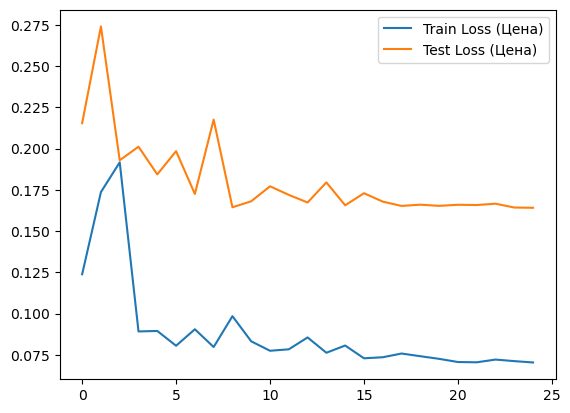

{'loss': [0.12385326623916626, 0.17365165054798126, 0.1917075365781784, 0.08915761858224869, 0.08943621814250946, 0.08047842979431152, 0.09047631174325943, 0.07970570027828217, 0.09840680658817291, 0.08315064758062363, 0.07743385434150696, 0.07831918448209763, 0.08551684767007828, 0.0762273445725441, 0.08061345666646957, 0.07287541776895523, 0.07349810749292374, 0.07576292753219604, 0.07413089275360107, 0.07253558933734894, 0.0706123560667038, 0.07043491303920746, 0.07209356129169464, 0.07115667313337326, 0.07033237814903259], 'val_loss': [0.21543508768081665, 0.2740876376628876, 0.19295519590377808, 0.20117804408073425, 0.18440750241279602, 0.198473259806633, 0.17252829670906067, 0.21760544180870056, 0.1644420623779297, 0.16809788346290588, 0.17716975510120392, 0.17195862531661987, 0.16734860837459564, 0.17953437566757202, 0.16564230620861053, 0.172977015376091, 0.16788019239902496, 0.1652728021144867, 0.1660241186618805, 0.16531139612197876, 0.16597290337085724, 0.16581213474273682, 

In [27]:
model, compatible_n_batch = _create_model(train_X, train_Y, test_X, test_Y, n_neurons, n_batch, n_epochs,
                                          is_stateful, has_memory_stack, loss_function, optimizer_function,
                                          draw_loss_plot, output_col_name, verbose)
#model.save('./my_model_%s.h5'%datetime.datetime.now())
# model.save('./my_model_in time step_%d_out_timestep_%d.h5'%n_in_timestep%n_out_timestep)

17/17 [==============================] - 0s 6ms/step

Test Root Mean Square Error: 1222.446
Test Average Value for Цена: 5318.641
Test Average Error Percentage: 22.98/100.00


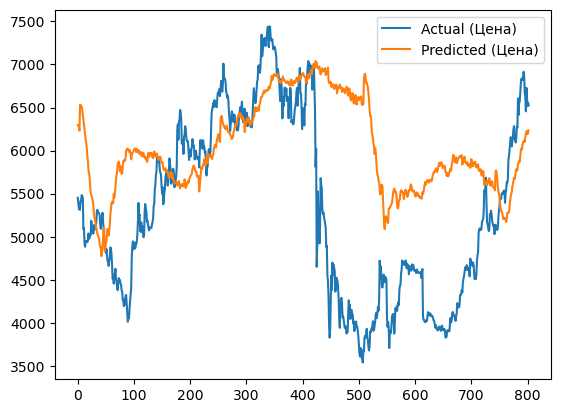

In [28]:

#!input
draw_prediction_fit_plot = True
actual_target, predicted_target, error_value, error_percentage = _make_prediction(model, train_X, train_Y,
                                                                                  test_X, test_Y, compatible_n_batch,
                                                                                  n_in_timestep, n_features, scaler,
                                                                                  draw_prediction_fit_plot, output_col_name,
                                                                                  verbose)